In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deep_gravity_utils as dgu
import scipy.linalg as scilinalg
import ipdb

In [54]:
dgu.setup_seed(12)

# Visualization of adjacency matrix (connectivity.csv)

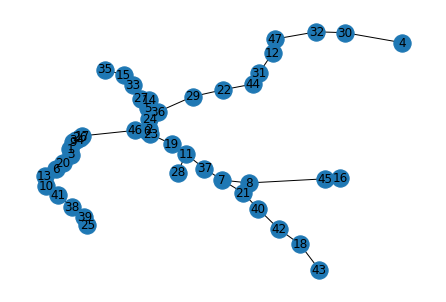

In [55]:
import networkx as nx

adj_mat = pd.read_csv('./data/connectivity.csv', index_col=0).to_numpy()[:48, :48]
station_coor = pd.read_csv('./data/station-coor.csv', index_col=0).iloc[:48, :]

pos0 = np.array(station_coor[['lon', 'lat']])
npos = dict(zip(np.array(station_coor.index), pos0))  # 获取节点与坐标之间的映射关系，用字典表示

G = nx.from_numpy_matrix(adj_mat)
nx.draw(G, with_labels=True, pos=npos)

In [56]:
path = nx.all_pairs_dijkstra_path(G)
path

<generator object all_pairs_dijkstra_path at 0x000001BED232E970>

In [57]:
A_mode = adj_mat+np.eye(adj_mat.shape[0])
D_mode = np.zeros_like(A_mode)
np.fill_diagonal(D_mode, A_mode.sum(axis=1))
D_mode_inv_root = np.linalg.inv(scilinalg.sqrtm(D_mode))
A_mode = D_mode_inv_root @ A_mode @ D_mode_inv_root


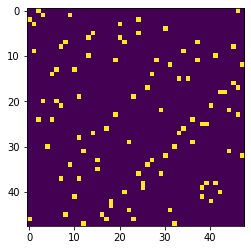

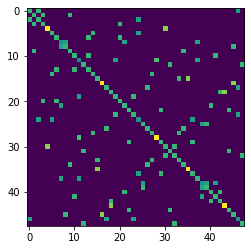

In [58]:
plt.figure()
plt.imshow(adj_mat)
plt.figure()
plt.imshow(A_mode)

## Reading data (daily)

In [59]:
config = pd.read_csv('config.csv')
year = config.loc[0, 'year']
OD = np.load('./data/3d_%i_30days.npy'%year)[:48, :48]

data_X_org = pd.read_csv('./data/data_X.csv', index_col=0).iloc[:48, :]
adj_mat = pd.read_csv('./data/connectivity.csv', index_col=0).iloc[:48, :48].to_numpy()
stops = pd.read_csv('./data/stops_order.csv', index_col=0).iloc[:48, :]

print('Year', year)

Year 2020


In [60]:
OD.shape

(48, 48, 720)

In [61]:
t_past = config.loc[0, 't_past']
t_future = config.loc[0, 't_pre']
OD_4d = dgu.const_4d_OD(OD, t_past, t_future)

Memory occupied 113.9062 MB


In [62]:
# daily ridership data
print(OD_4d.shape)
print(data_X_org.shape)
print(adj_mat.shape)
print(stops.shape)

(711, 9, 48, 48)
(48, 21)
(48, 48)
(48, 1)


In [63]:
# Initialization of hyper parameters
inp_size = OD_4d.shape[-1]
print('Input size is %i'%inp_size)

Input size is 48


# Gravity Model Inspired Neural Network (FC)

In [64]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [65]:
# Model specification
class GraphRidershipNet(nn.Module):
    def __init__(self, adj_mat, inp_size, inp_ch_size, t_future, feature_size=18, dropout_p=0.0):
        super(GraphRidershipNet, self).__init__()
        
        self.adj_mat = adj_mat
        self.inp_size = inp_size
        self.inp_ch_size = inp_ch_size
        self.feature_size = feature_size
        self.t_future = t_future
        
        '''
        self.e1 = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch_size, out_channels=32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
            
        self.e2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        
        self.e3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Dropout(dropout_p),
        )
        
        self.d3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
            
        self.d4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
            
        self.d5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=t_future, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        '''
        self.conv_in = nn.Sequential(
            nn.Conv2d(in_channels=inp_ch_size, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_p),
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        self.conv_mid = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        self.conv_out = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=t_future, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        
    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        '''
        s = self.inp_size
        f = self.feature_size
        e1 = self.e1(torch.matmul(x, self.adj_mat) )
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = e3.view(-1, 128*(s//8)*(s//8))
        e5 = nn.Linear(in_features=e4.shape[-1], out_features=f, device=device)(e4)  # hidden features

        d1 = nn.Linear(in_features=f, out_features=128*(s//8)*(s//8), device=device)(e5)
        d2 = d1.view(-1, 128, s//8, s//8)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = torch.matmul(self.d5(d4), self.adj_mat)
        '''
        
        x = self.conv_in(torch.matmul(self.adj_mat, x))
        x = self.conv1(torch.matmul(self.adj_mat, x))
        x = self.conv1(torch.matmul(self.adj_mat, x))
        x = self.conv_mid(torch.matmul(self.adj_mat, x))
        x = self.conv2(torch.matmul(self.adj_mat, x))
        x = self.conv_out(x)

        return x
    

## Train the model

In [66]:
# #############################
# Preparing data for PyTorch
# #############################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prop = config.loc[0, 'prop']
l = int(OD_4d.shape[0]*prop)

X_train = OD_4d[:l, :t_past, :, :]
y_train = OD_4d[:l, t_past:, :, :]
X_val = OD_4d[l:, :t_past, :, :]
y_val = OD_4d[l:, t_past:, :, :]

In [67]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
adj_mat = torch.tensor(adj_mat, dtype=torch.float32).to(device)
A_mode = torch.tensor(A_mode, dtype=torch.float32).to(device)

batch_size = 256
loader_train = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train), batch_size, shuffle=True
)

iter_train = iter(loader_train)


In [68]:
print(X_train.shape)
print(y_train.shape)


torch.Size([497, 5, 48, 48])
torch.Size([497, 4, 48, 48])


In [69]:
# Train the model by inputing 
# [land use data and trip data (demand at each region)] 
# to the model, then output one column of OD
inp_ch_size = t_past
model = GraphRidershipNet(A_mode, inp_size, inp_ch_size, t_future, feature_size=data_X_org.shape[1]-3).to(device)
loss_func = nn.MSELoss()
loss_set_train = []
loss_set_val = []
hid_set = []


In [70]:
optimizer = optim.Adam(model.parameters())

In [71]:
# summary(model, [300,inp_ch_size,48,48])

In [72]:
model.train()

epochs = 1500

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs+1):
    #ipdb.set_trace()
    for i in range(len(loader_train)):
        try:
            X, y = iter_train.next()
        except:
            iter_train = iter(loader_train)
            X, y = iter_train.next()
        
        out = model(X)
#         ipdb.set_trace()
        loss = loss_func(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if e%50==0:
        out_val = model(X_val)
        loss_val = loss_func(out_val, y_val)
        loss_set_val.append(loss_val.cpu().detach().numpy())
        loss_set_train.append(loss.cpu().detach().numpy())
    
        print('Epoch %i   success, val loss:%.6f, train loss:%.6f'%(
            e, loss_val.cpu().detach().numpy(), loss.cpu().detach().numpy()
        ))
        

Epoch 0   success, val loss:1.499863, train loss:1.592292
Epoch 50   success, val loss:1.112990, train loss:1.279963
Epoch 100   success, val loss:0.996722, train loss:1.339792
Epoch 150   success, val loss:0.940446, train loss:1.163735
Epoch 200   success, val loss:0.909876, train loss:0.918272
Epoch 250   success, val loss:0.883008, train loss:0.992316
Epoch 300   success, val loss:0.924475, train loss:1.117205
Epoch 350   success, val loss:0.845834, train loss:1.025243
Epoch 400   success, val loss:0.830537, train loss:1.094923
Epoch 450   success, val loss:0.823405, train loss:0.986078
Epoch 500   success, val loss:0.812013, train loss:0.873861
Epoch 550   success, val loss:0.803639, train loss:0.982641
Epoch 600   success, val loss:0.793447, train loss:1.066958
Epoch 650   success, val loss:0.785362, train loss:1.008886
Epoch 700   success, val loss:0.778515, train loss:0.925908
Epoch 750   success, val loss:0.775384, train loss:0.902838
Epoch 800   success, val loss:0.770815, tra

In [73]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Epoches/50')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Epoches/50')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Training loss')
    ax2.grid()
    plt.suptitle(title)

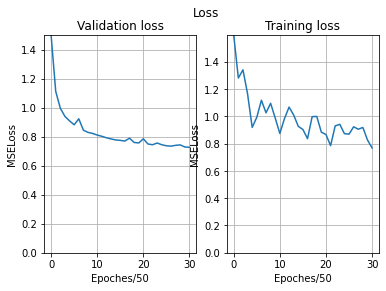

In [74]:
plot_loss(loss_set_val, loss_set_train, 'Loss')

In [75]:
out_val.shape

torch.Size([214, 4, 48, 48])

In [ ]:
h = t_future-1
pred = out_val.cpu().detach().numpy()
pred = np.transpose(pred, (1, 2, 3, 0)).reshape(t_future, -1).T
np.save('./res/%.1f/convgraph_%i.npy'%(prop, year), pred)
labels = y_val.cpu().detach().numpy()
labels = np.transpose(labels, (1, 2, 3, 0)).reshape(t_future, -1).T
print(pred.shape)

m = config.loc[0, 'mask']

print('The mae loss is %.4f'%dgu.mae_loss_func(pred, labels, m))
print('The mape loss is %.4f'%dgu.mape_loss_func(pred, labels, m))
print('The smape loss is %.4f'%dgu.smape_loss_func(pred, labels, m))
print('The nrmse loss is %.4f'%dgu.nrmse_loss_func(pred, labels, m))
print('The nmae loss is %.4f'%dgu.nmae_loss_func(pred, labels, m))

plt.figure(figsize=[20, 6])
plt.plot(labels[:, h], '-', label='true', c='b')
plt.plot(pred[:, h], '-', label='pred', c='r', alpha=0.8)
plt.legend()

In [ ]:
pred = out_val.cpu().detach().numpy().sum(axis=0)
labels = y_val.cpu().detach().numpy().sum(axis=0)

m = config.loc[0, 'mask']

print('The mae loss is %.4f'%dgu.mae_loss_func(pred, labels, m))
print('The mape loss is %.4f'%dgu.mape_loss_func(pred, labels, m))
print('The smape loss is %.4f'%dgu.smape_loss_func(pred, labels, m))
print('The nrmse loss is %.4f'%dgu.nrmse_loss_func(pred, labels, m))
print('The nmae loss is %.4f'%dgu.nmae_loss_func(pred, labels, m))

fig = plt.figure(figsize=[20,10])

ax1 = fig.add_subplot(121)
ax1.imshow(pred[0,:,:])
ax1.set_title('Predicted OD')

ax2 = fig.add_subplot(122)
ax2.imshow(labels[0,:,:])
ax2.set_title('Real OD')

In [ ]:
print('CPC is %.5f'%dgu.get_CPC(pred, labels))

In [ ]:
# torch.save(model.to('cpu').state_dict(), './models/model_48stations_graph.pth')

## Preliminary visualization of the prediction upon the validation dataset

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prop = 0.7
l = int(OD_4d.shape[0]*prop)

X_val = torch.tensor(OD_4d[l:, :t_past+1, :, :], dtype=torch.float32).to(device)
y_val = torch.tensor(OD_4d[l:, t_past+1:, :, :], dtype=torch.float32).to(device)

model = GraphRidershipNet(adj_mat, inp_size, inp_ch_size, t_future, feature_size=data_X_org.shape[1]-3).to(device)
model.load_state_dict(torch.load('./models/model_48stations_graph.pth'))
model.eval()

out_val = model(X_val)

In [15]:
summary(model, [300,inp_ch_size,48,48]) 

Layer (type:depth-idx)                   Output Shape              Param #
GraphRidershipNet                        --                        --
├─Sequential: 1-1                        [300, 32, 47, 47]         --
│    └─Conv2d: 2-1                       [300, 32, 47, 47]         1,472
│    └─ReLU: 2-2                         [300, 32, 47, 47]         --
│    └─Dropout: 2-3                      [300, 32, 47, 47]         --
├─Sequential: 1-2                        [300, 32, 47, 47]         --
│    └─Conv2d: 2-4                       [300, 32, 47, 47]         9,248
│    └─ReLU: 2-5                         [300, 32, 47, 47]         --
│    └─Dropout: 2-6                      [300, 32, 47, 47]         --
├─Sequential: 1-3                        [300, 32, 47, 47]         (recursive)
│    └─Conv2d: 2-7                       [300, 32, 47, 47]         (recursive)
│    └─ReLU: 2-8                         [300, 32, 47, 47]         --
│    └─Dropout: 2-9                      [300, 32, 47, 47]   

Text(0.5, 1.0, 'Real OD')

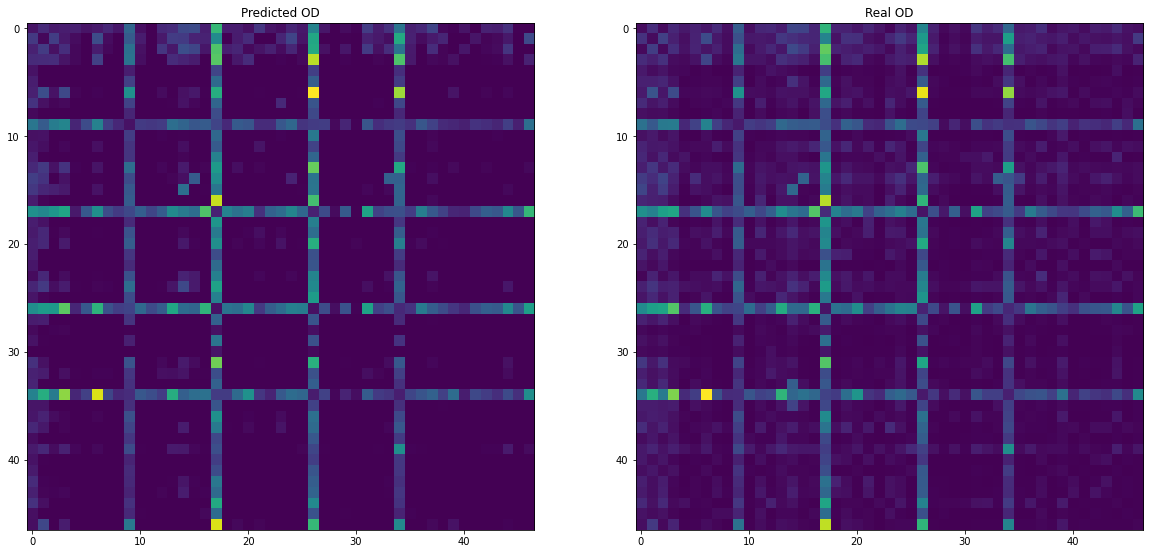

In [20]:
fig = plt.figure(figsize=[20,10])

ax1 = fig.add_subplot(121)
ax1.imshow(out_val.cpu().detach().numpy().sum(axis=0)[0,:,:])
ax1.set_title('Predicted OD')

ax2 = fig.add_subplot(122)
ax2.imshow(y_val.cpu().detach().numpy().sum(axis=0)[0,:,:])
ax2.set_title('Real OD')

In [17]:
# Input the data from the Bay area to evaluate
# whether the model is practical

In [18]:
y_val.cpu().detach().numpy().sum(axis=0).shape

(2, 47, 47)

In [27]:
pred = out_val.cpu().detach().numpy().sum(axis=0)
labels = y_val.cpu().detach().numpy().sum(axis=0)

m = config.loc[0, 'mask']

print('The mae loss is %.4f'%dgu.mae_loss_func(pred, labels, m))
print('The mape loss is %.4f'%dgu.mape_loss_func(pred, labels, m))
print('The smape loss is %.4f'%dgu.smape_loss_func(pred, labels, m))
print('The nrmse loss is %.4f'%dgu.nrmse_loss_func(pred, labels, m))
print('The nmae loss is %.4f'%dgu.nmae_loss_func(pred, labels, m))



The mae loss is 4212.4473
The mape loss is 0.6225
The smape loss is 0.7403
The nrmse loss is 0.0289
The nmae loss is 0.0197


In [28]:
def get_CPC(pred, labels):
    res_min = np.concatenate([pred, labels], axis=1).min(axis=1).flatten()
    CPC = np.sum(res_min)*2 / (np.sum(pred) + np.sum(labels))
    return CPC

In [29]:
print('CPC is %.5f'%get_CPC(pred, labels))

CPC is 0.00027


# Visualization of trips on map

In [30]:
import geopandas as gpd

In [31]:
data_X_all = gpd.read_file('./data/data_X_all.shp')

In [32]:
data_X_all.head(2)

,GEOID,INTPTLAT,INTPTLON,TotPop,CSA,CSA_Name,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,...,D4C,D4D,D5AR,D5AE,NatWalkInd,COUNTYID,if_keep,nearest st,transit di,geometry
0,06001983200,37.804224,-122.27715,11084.0,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",1664.0,2208.0,...,71.028333,707.012491,1891149.0,1455141.0,16.972222,06001,1.0,12TH,0.895287,"POLYGON ((-122.28374 37.79480, -122.28343 37.7..."
1,06075020500,37.769279,-122.43602,142973.0,488.0,"San Jose-San Francisco-Oakland, CA",41860.0,"San Francisco-Oakland-Berkeley, CA",20505.0,29075.0,...,30.318892,697.115918,16339411.0,11103193.0,16.600806,06075,1.0,16TH,2.424009,"POLYGON ((-122.43467 37.75611, -122.43564 37.7..."


In [33]:
bart_coor = pd.read_csv('./data/station-coor.csv', index_col=0)
bart_coor.head(2)

,abbr,lat,lon
0,12TH,37.803768,-122.271450
1,16TH,37.765062,-122.419694


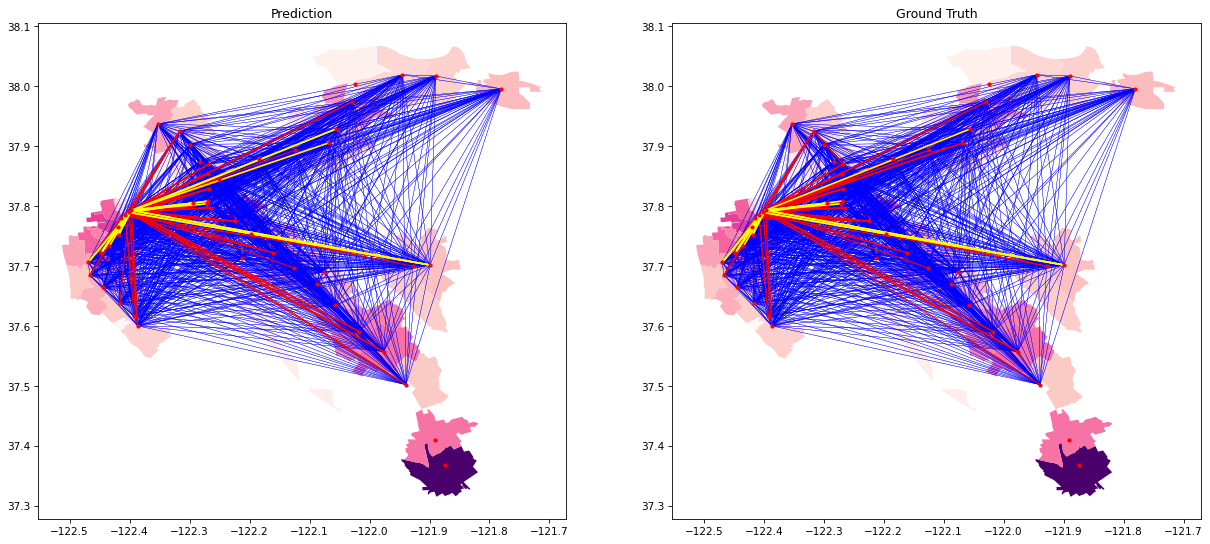

In [34]:
pred = out_val.cpu().detach().numpy().sum(axis=0)[0, :, :]
labels = y_val.cpu().detach().numpy().sum(axis=0)[0, :, :]

fig = plt.figure(figsize=[20, 10], dpi=75)
ax0 = fig.add_subplot(121)
ax0.set_title('Prediction')
ax1 = fig.add_subplot(122)
ax1.set_title('Ground Truth')

data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')
data_X_all.plot(column='TotPop', ax=ax1, cmap='RdPu')

# plot trips
num_pred_stations = pred.shape[0] // 50  # 50 means that there are 50 stations in total
pred_stations = stops.iloc[-num_pred_stations:, 0]

low_lon_pred_dest = []
low_lat_pred_dest = []
mid_lon_pred_dest = []
mid_lat_pred_dest = []
high_lon_pred_dest = []
high_lat_pred_dest = []
low_lon_pred_origin = []
low_lat_pred_origin = []
mid_lon_pred_origin = []
mid_lat_pred_origin = []
high_lon_pred_origin = []
high_lat_pred_origin = []

low_lon_labels_dest = []
low_lat_labels_dest = []
mid_lon_labels_dest = []
mid_lat_labels_dest = []
high_lon_labels_dest = []
high_lat_labels_dest = []
low_lon_labels_origin = []
low_lat_labels_origin = []
mid_lon_labels_origin = []
mid_lat_labels_origin = []
high_lon_labels_origin = []
high_lat_labels_origin = []

for i in pred_stations.index:
    station_dest = pred_stations.loc[i]
    for j in stops.index:
        station_origin = stops.loc[j, 'stop']
        
        lon_origin = bart_coor.loc[bart_coor['abbr']==station_origin, 'lon'].values[0]
        lat_origin = bart_coor.loc[bart_coor['abbr']==station_origin, 'lat'].values[0]
        lon_dest = bart_coor.loc[bart_coor['abbr']==station_dest, 'lon'].values[0]
        lat_dest = bart_coor.loc[bart_coor['abbr']==station_dest, 'lat'].values[0]
        
        dest_ind = i
        origin_ind = j
        
        if pred[origin_ind, dest_ind]-pred.min()<(pred.max()-pred.min())*0.3:
            low_lon_pred_dest.append(lon_dest)
            low_lat_pred_dest.append(lat_dest)
            low_lon_pred_origin.append(lon_origin)
            low_lat_pred_origin.append(lat_origin)
#             ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'b', lw=0.1)
        elif pred[origin_ind, dest_ind]-pred.min()>=(pred.max()-pred.min())*0.3 and pred[origin_ind, dest_ind]-pred.min()<(pred.max()-pred.min())*0.6:
            mid_lon_pred_dest.append(lon_dest)
            mid_lat_pred_dest.append(lat_dest)
            mid_lon_pred_origin.append(lon_origin)
            mid_lat_pred_origin.append(lat_origin)
#             ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'red', lw=0.6)
        elif pred[origin_ind, dest_ind]-pred.min()>=(pred.max()-pred.min())*0.6:
            high_lon_pred_dest.append(lon_dest)
            high_lat_pred_dest.append(lat_dest)
            high_lon_pred_origin.append(lon_origin)
            high_lat_pred_origin.append(lat_origin)
#             ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'yellow', lw=2)
        
        if labels[origin_ind, dest_ind]-labels.min()<(labels.max()-labels.min())*0.3:
            low_lon_labels_dest.append(lon_dest)
            low_lat_labels_dest.append(lat_dest)
            low_lon_labels_origin.append(lon_origin)
            low_lat_labels_origin.append(lat_origin)
#             ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'b', lw=0.1)
        elif labels[origin_ind, dest_ind]-labels.min()>=(labels.max()-labels.min())*0.3 and labels[origin_ind, dest_ind]-labels.min()<(labels.max()-labels.min())*0.6:
            mid_lon_labels_dest.append(lon_dest)
            mid_lat_labels_dest.append(lat_dest)
            mid_lon_labels_origin.append(lon_origin)
            mid_lat_labels_origin.append(lat_origin)
#             ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'red', lw=0.6)
        elif labels[origin_ind, dest_ind]-labels.min()>=(labels.max()-labels.min())*0.6:
            high_lon_labels_dest.append(lon_dest)
            high_lat_labels_dest.append(lat_dest)
            high_lon_labels_origin.append(lon_origin)
            high_lat_labels_origin.append(lat_origin)
#             ax1.plot([lon_origin, lon_dest], [lat_origin, lat_dest], 'yellow', lw=2)

for i in range(len(low_lon_pred_dest)):
    ax0.plot([low_lon_pred_origin[i], low_lon_pred_dest[i]], [low_lat_pred_origin[i], low_lat_pred_dest[i]], 'b', lw=0.3)
    
for i in range(len(mid_lon_pred_dest)):
    ax0.plot([mid_lon_pred_origin[i], mid_lon_pred_dest[i]], [mid_lat_pred_origin[i], mid_lat_pred_dest[i]], 'red', lw=1)
    
for i in range(len(high_lon_pred_dest)):
    ax0.plot([high_lon_pred_origin[i], high_lon_pred_dest[i]], [high_lat_pred_origin[i], high_lat_pred_dest[i]], 'yellow', lw=1.5)

for i in range(len(low_lon_labels_dest)):
    ax1.plot([low_lon_labels_origin[i], low_lon_labels_dest[i]], [low_lat_labels_origin[i], low_lat_labels_dest[i]], 'b', lw=0.3)
    
for i in range(len(mid_lon_labels_dest)):
    ax1.plot([mid_lon_labels_origin[i], mid_lon_labels_dest[i]], [mid_lat_labels_origin[i], mid_lat_labels_dest[i]], 'red', lw=1)
    
for i in range(len(high_lon_labels_dest)):
    ax1.plot([high_lon_labels_origin[i], high_lon_labels_dest[i]], [high_lat_labels_origin[i], high_lat_labels_dest[i]], 'yellow', lw=1.5)



# plot stations
for i in bart_coor.index:
    lon = bart_coor.loc[i, 'lon']
    lat = bart_coor.loc[i, 'lat']
    ax0.plot(lon, lat, 'r.')
    ax1.plot(lon, lat, 'r.')



In [87]:
# fig.savefig('./outputs/comp.jpg', dpi=700)